## 通し課題　課題①Kickstarter Projects

### DAY3受講後の目標
- DAY1～DAY3で学んだ各手法の精度比較。DAY3は木モデルをベースとしたアンサンブル学習を目標とする。
- 余裕があればCNNモデルにも取り組んでみる（後日になりそう）

#### 【注意事項】Slackより（DAY3追記）
- なるべくfor ループを使わずに、pandasの関数で完結させるのが良い。forループを使うと計算が遅くなる
- pd.to_datetime()を使うと、timedate型に1発で変換できる
- csvデータを読み込むときは、まずは、対象の列を指定せずに、全て読み込んで、どんなデータが入っているのかを確認しよう
- 散布図を描くとき、データが重なって見にくい場合は、markerを小さくし、半透明にすると、見やすくなる
- dropnaを行うときは、タイミングが大事。早い段階でdropnaすると、使えるデータを落としてしまうことになる
- pd.get_dummies()を実行するときは、対象とする列を選択すること。不要な列を含めてしまうと、計算が重くなり、パソコンが固まってしまう
- カテゴリデータを数字化するとき、labelEncoderを使うと、連続的な数字になってしまい、数字の大小に意味が発生してしまうことに注意
- 標準化や正規化は、train_test_splitした後に行いましょう。
- 正則化係数やSVMのCなどのハイパーパラメータは、適切な値を探索しましょう。デフォルトをそのまま用いてもうまくいきません。
- グリッドサーチを行うときは、候補値の範囲や間隔が適切かどうかをよく検討しましょう。
- 手法どうしを汎化誤差で比較する場合は、用いるテストデータなどの条件を揃えましょう。
- サンプリングしたデータで学習する場合、まず、全学習データをtrainとtestにわけ、そのtarinの中から1%とか5%を抜き出して学習するようにしましょう。

In [50]:
%matplotlib inline

#import os
#import codecs
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
import category_encoders as ce  # カテゴリーエンコーダを使ってみる
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, mean_squared_error, mean_absolute_error 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

### １ Read data-set

In [2]:
# Read data-set "ks-projects-201801.csv”
df_ks = pd.read_csv("data/01 Kickstarter Projects/ks-projects-201801.csv")

In [3]:
# Display original data-set
display(df_ks.info())
display(df_ks.head(), df_ks.tail())
display(df_ks.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


None

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,canceled,1,US,25.0,25.0,50000.0
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,failed,5,US,155.0,155.0,1500.0
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,failed,1,US,20.0,20.0,15000.0
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,failed,6,US,200.0,200.0,15000.0
378660,999988282,Nou Renmen Ayiti! We Love Haiti!,Performance Art,Art,USD,2011-08-16,2000.0,2011-07-19 09:07:47,524.0,failed,17,US,524.0,524.0,2000.0


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [4]:
df_ks.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

##### メモ　currency：通貨　goal系：目標額　pledged系：融資（申出）出額　backers：支援者数
- 成否判定は pledged が goal を超えたかどうかで判断できる（※福本さんはこれを使って回帰問題で解いていた）
- 説明変数として pledged, backers は使えない（目的変数とほぼほぼイコールであるため）
- usd_pledged の欠損値は使わないので無視してよい。name については、前処理の過程で穴埋めで対応する（後述）

In [5]:
# Extract "successful" & "failed" data from "state" column.
# ”state” ”failed”か”successful”のデータを抽出する (slackで共有された記述式に変更)

df_ks = df_ks[df_ks['state'].isin(['failed','successful'])]

In [6]:
# Removed unusable parameter
# 使わないデータをテーブルから削除
df_temp = df_ks.drop(['ID', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real'] , axis=1)

In [7]:
# Binarization
# state の文字データを０，１へ変換（DAY1_進捗シートコメントを参考） 
df_temp['state']= df_temp['state'] == 'successful'
df_temp.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,False,GB,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,False,US,30000.00
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,False,US,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,False,US,5000.00
5,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,True,US,50000.00


In [8]:
# Success rate (全体の成功率)
df_temp['state'].mean()

0.4038772895153388

### ２ Visualization & Analyzation

In [9]:
# deadline と launched から募集期間（term）を求める（DAY1_進捗シートコメントを参考）
df_term = pd.to_datetime(df_temp['deadline'])-pd.to_datetime(df_temp['launched'])
df_temp['term'] = df_term.dt.days
#df_temp.head()

- （メモ）termの最頻値は29（時間切り捨てのため実質30日？）
-  半数以上が約１か月の設定で実施していることが分かる

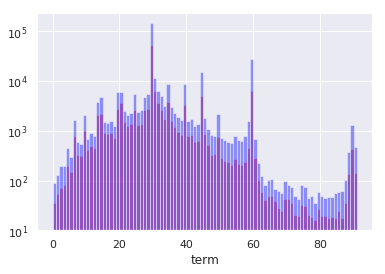

In [10]:
sns.distplot(df_temp['term'][df_temp['state'] ==1], kde=False, rug=False, color='red', bins=91)
sns.distplot(df_temp['term'], kde=False, rug=False, color='blue', bins=91)

plt.xlabel('term')
plt.yscale('log')  # 最大値が大きいのでlogスケール化
plt.show()

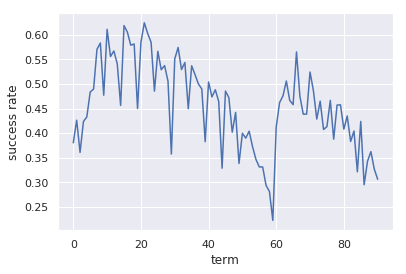

In [11]:
ret1 = plt.hist(df_temp['term'], color='blue', alpha=0.5, bins=91)
ret2 = plt.hist(df_temp['term'][df_temp['state']==1], color='red', alpha=0.5, bins=91)

plt.gca().clear()

ret3 = ret2[0]/ret1[0]
s = pd.Series(ret3)
plt.plot(s)

plt.xlabel('term')
plt.ylabel('success rate')

plt.show()

- 最も多いのは30日　時点で60日
- 募集期間における成功率の分布には２つの山がある。谷底は60日の部分
- なぜ60日で成功率が悪くなるのか？ ⇒　60日を超えるとデータ数が大きく減っているのも影響している？

#### name の処理方法について　⇒　山崎氏のDAY1_work資料を参考に　※「単語の多さ」に着目する

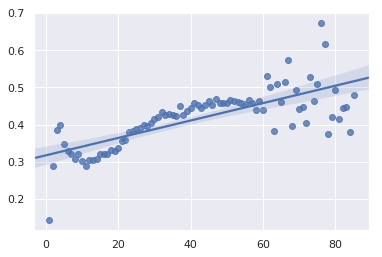

In [12]:
# 山崎氏のnotebookを参考
# 文字数とstateの平均値との散布図を描画
df_noc = df_temp.loc[:,['name', 'state']]
df_noc['NoC'] = df_noc.name.str.len()   # Number of Characters
z = df_noc.groupby('NoC').state.mean()
sns.regplot(z.index.array, z.values, order=1)  # 直線近似

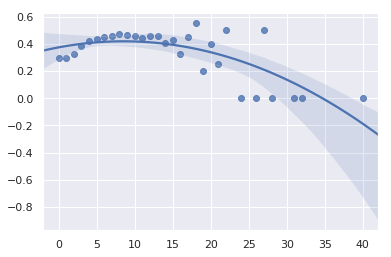

In [13]:
# 山崎氏のnotebookを参考
# スペースの数から単語数を推定する手法、スペース数＋１を単語数として、stateの平均値との散布図を描画
df_wor = df_temp.loc[:,['name', 'state']]
df_wor['word'] = df_wor.name.str.count(" ")
z = df_wor.groupby('word').state.mean()
sns.regplot(z.index.array, z.values, order=2)  # ２次関数近似

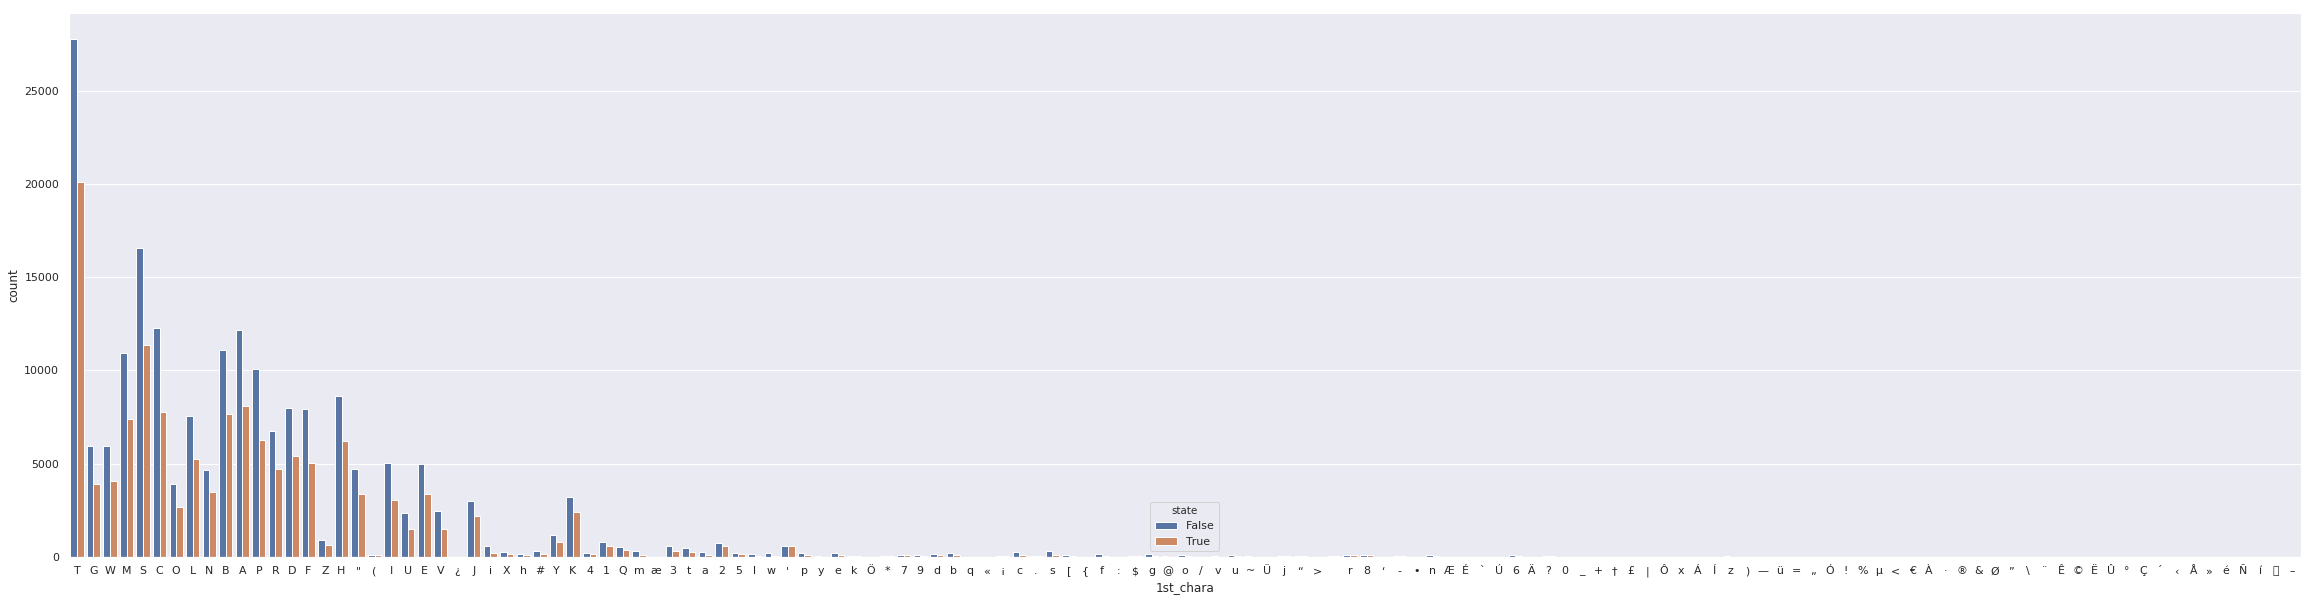

In [14]:
# アルファベット順にしたときの成功率の差を見る
df_1st = df_temp.loc[:,['name', 'state']]

# 先頭の文字のみを切出し
df_1st['1st_chara'] = df_1st.name.str[0]

plt.figure(figsize=(40, 10))

pd.get_dummies(df_1st['1st_chara'])
sns.countplot(x='1st_chara', data = df_1st, hue='state');

- いわゆる特殊文字が予想以上に多く入っている？　何らかの処理方法を考えないと、このままでは使えなさそう。（思いつかない・・・）
- あまり先頭文字は関係ない？
- T が多いのは”The”で始まることが多いから？
#### 　⇒　文字数及び単語数を両方使う

#### goal, usd_goal_real の処理方法について

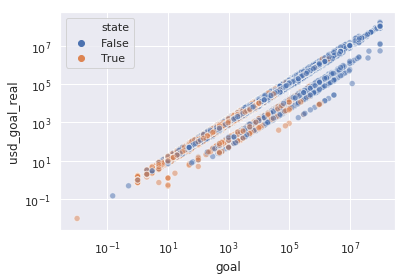

In [15]:
# goal, usd_goal_real を散布図で確認
sns.scatterplot(x='goal', y='usd_goal_real', data=df_temp, color='red', alpha=0.5, hue='state')

plt.yscale('log')  
plt.xscale('log')  

plt.xlabel('goal')
plt.ylabel('usd_goal_real')

plt.show()

- 為替レートの関係で傾きが変わっていると思われるが、おおよそ比例関係にある？

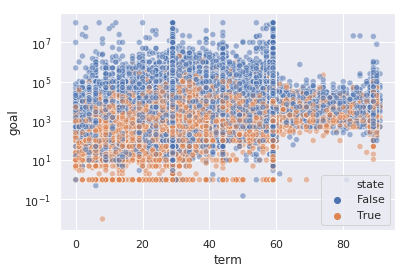

In [16]:
# 募集期間と目標額における成否分布
sns.scatterplot(x='term', y='goal', data=df_temp, color='red', alpha=0.5, hue='state')

plt.yscale('log')  # goalの最大値が大きいのでlogスケール化
plt.show()

In [17]:
# 上記２変数をロジスティック回帰にかけてみる
y = df_temp["state"].values
X = df_temp[["term", "goal"]].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

w0 = 9415.592, w1 = 247013.421, w2 = -367.702


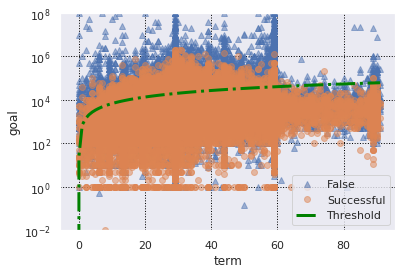

In [18]:
x1, x2 = df_temp["term"].values, df_temp["goal"].values 

# データをプロット
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')

plt.plot(x1[~y], x2[~y], '^', color='C0', label='False', alpha=0.5)
plt.plot(x1[y], x2[y], 'o', color='C1', label='Successful', alpha=0.5)

# 境界線をプロットして表示
# 紫：境界線
line_x = np.arange(np.min(x1) - 1, np.max(x1) + 1)
line_y = - line_x * w1 / w2 - w0 / w2
plt.plot(line_x, line_y, linestyle='-.', linewidth=3, color='green', label='Threshold')
#plt.ylim([np.min(x2) - 1, np.max(x2) + 1])
plt.ylim([np.min(x2), np.max(x2)])
plt.legend(loc='best')

plt.xlabel("term")
plt.ylabel("goal")
plt.yscale('log')
plt.show()

In [19]:
# ラベルを予測
y_pred = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_pred)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_pred)))

対数尤度 = -16.874
正答率 = 51.146%


- 同じ募集期間であれば目標額は低いほうが成功しやすいようである
- 傾向としては説明できそうだが、領域が重なっているので、これらの情報だけで判断するのは難しそう ⇒　ロジスティック回帰で確認

In [20]:
df_ks[df_ks['goal']==df_ks['goal'].min()]  # goal最小値（１ドル）のデータ確認

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
304489,620302213,LOVELAND Round 6: A Force More Powerful,Conceptual Art,Art,USD,2009-12-04,0.01,2009-11-25 07:54:49,100.0,successful,6,US,100.0,100.0,0.01


- ビジネスとしてAIを使うにあたり、”目的によっては” 上記のようなデータは外れ値とするべきではないか？

#### その他のカテゴリカル変数の処理について　⇒　Target Encoding と One-Hot Encoding を使ってみる
#### 参考：https://www.takapy.work/entry/2019/12/10/085810　https://qiita.com/daikiclimate/items/dd5606ede544e53db5a7　など

- （メモ）Target Encording は性質上、容易に目的変数を推定できてしまうため、データ漏洩の危険性があることから、実務上は別の手法を使う必要がある場合が多いとのこと。
- DAY2　指摘事項より、キックスターターのように変数が多い場合、漏洩の危険性は低くなるとのこと（１変数だけ推定するのは困難かつ１変数だけでは意味を成さないため？）

## 【注意事項】DAY2時は、テストデータ側も事前にエンコードしていた。必ず、訓練データと分けた後で実施すること。（ここではグラフ描画するために使っている

#### currency, country の処理方法について

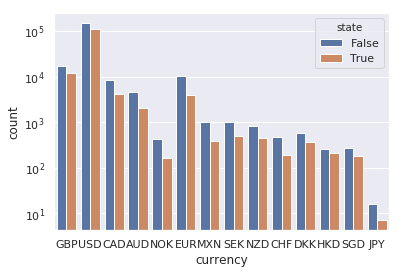

In [21]:
# currency について
sns.countplot(x='currency', data = df_temp, hue='state');
plt.yscale('log')


- ほとんどの通貨で成功率４割前後であるが、JPY（円）の成功率が悪い？

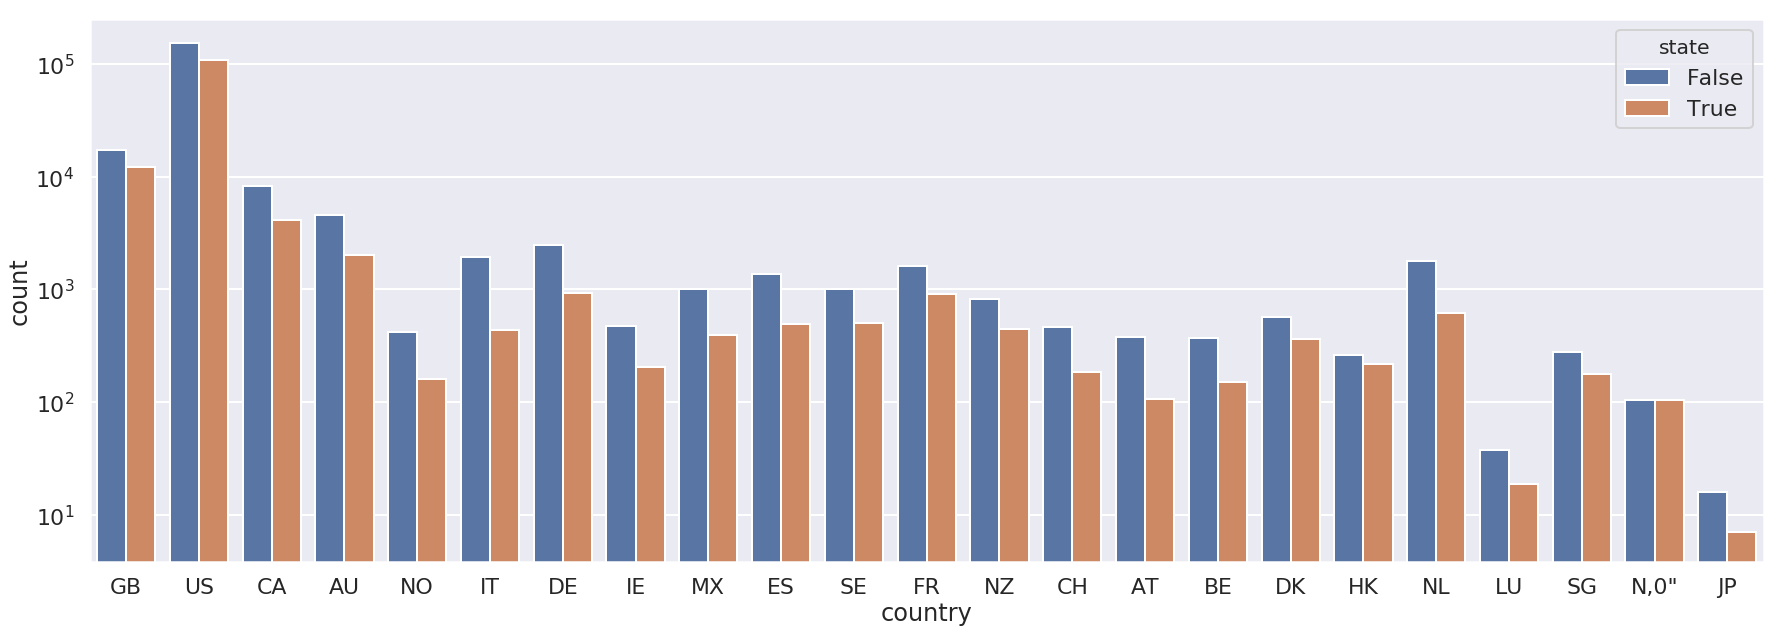

In [22]:
# country について
plt.figure(figsize=(30, 10))
sns.set_context('poster')  #フォントサイズを調整
plt.yscale('log')
sns.countplot(x='country', data = df_temp, hue='state');

sns.set_context('notebook')  #フォントサイズを元に戻す

- だいたい通貨と同じ感じ

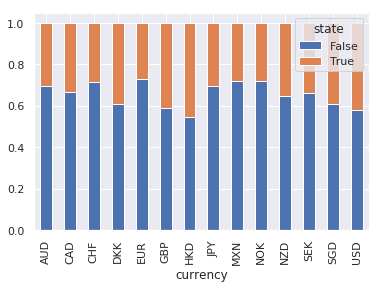

In [23]:
# currency(通貨)について：100%積み上げ棒グラフで描画してみる
mc = pd.crosstab(df_temp['currency'], df_temp['state'], normalize='index')
# stacked=Trueで積み上げ機能オン
mc.plot.bar(stacked=True)

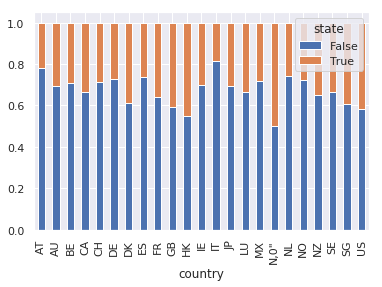

In [24]:
# country(国)について：100%積み上げ棒グラフで描画してみる
mc = pd.crosstab(df_temp['country'], df_temp['state'], normalize='index')
# stacked=Trueで積み上げ機能オン
mc.plot.bar(stacked=True)

- Target Encoding で上手く処理できると思われる。

#### 続いて大分類（main_category）, 小分類（category） をどのように使うか？
#### ⇒　まずは大分類、小分類の項目、データ数をチェック

In [25]:
# main_category を変換 
df_ma = pd.get_dummies(df_temp['main_category'])
df_ma.sum()

Art             25641
Comics           9878
Crafts           7818
Dance            3573
Design          25364
Fashion         19775
Film & Video    56527
Food            22054
Games           28521
Journalism       4149
Music           45949
Photography      9689
Publishing      35445
Technology      27050
Theater         10242
dtype: int64

In [26]:
# category を変換 
df_ca = pd.get_dummies(df_temp['category'])
df_ca.sum()

3D Printing            568
Academic               777
Accessories           2740
Action                 621
Animals                229
Animation             2213
Anthologies            737
Apparel               6166
Apps                  5287
Architecture           642
Art                   7486
Art Books             2469
Audio                  363
Bacon                  181
Blues                  234
Calendars              290
Camera Equipment       350
Candles                378
Ceramics               275
Children's Books      6198
Childrenswear          418
Chiptune                33
Civic Design           266
Classical Music       2440
Comedy                2068
Comic Books           2493
Comics                4581
Community Gardens      271
Conceptual Art         930
Cookbooks              455
                     ...  
Shorts               11394
Small Batch           1621
Software              2573
Sound                  551
Space Exploration      283
Spaces                 755
S

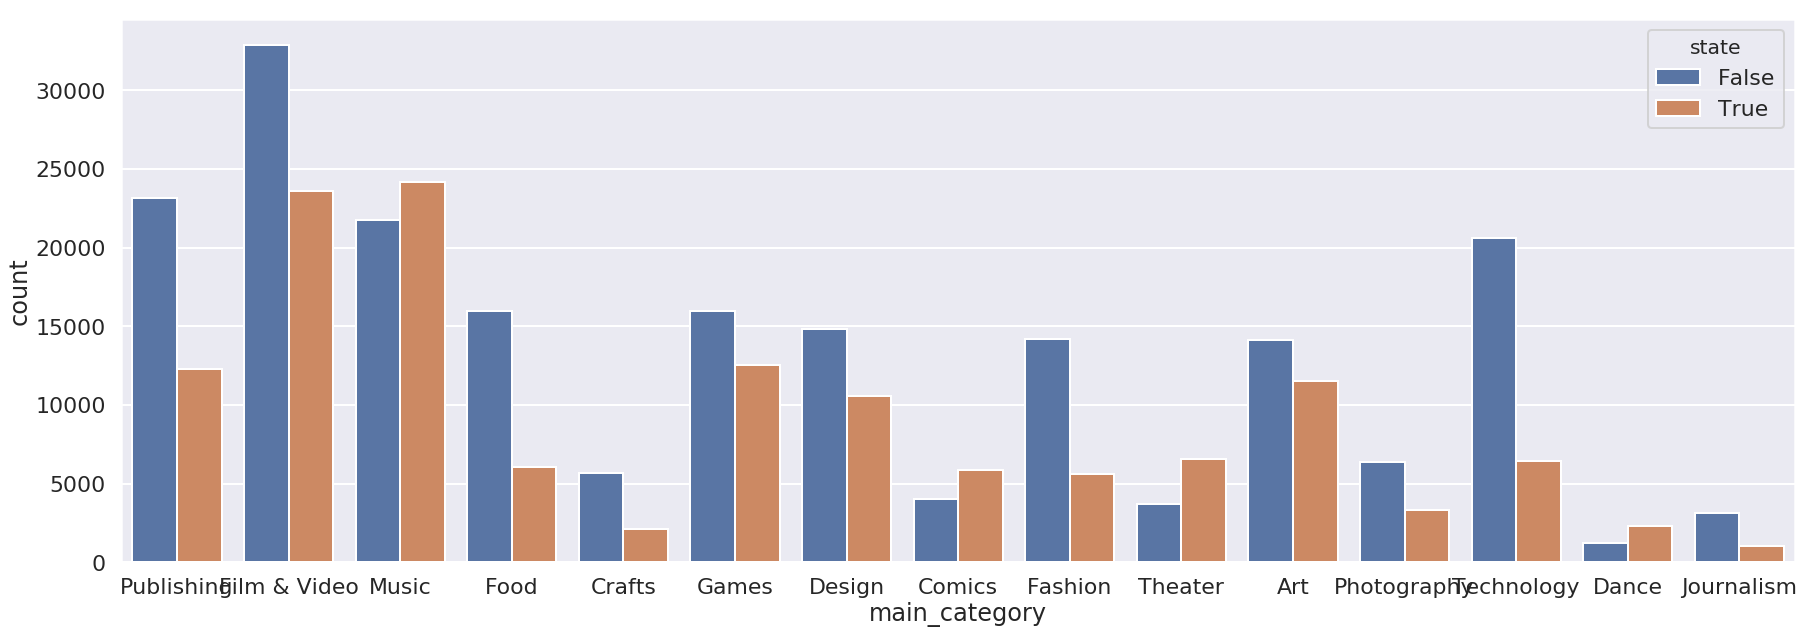

In [27]:
# main_category について
plt.figure(figsize=(30, 10))
sns.set_context('poster')  #フォントサイズを調整

sns.countplot(x='main_category', data = df_temp, hue='state');

sns.set_context('notebook')  #フォントサイズを元に戻す

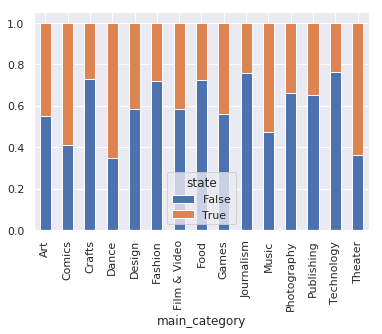

In [28]:
# 100%積み上げ棒グラフで描画してみる
mc = pd.crosstab(df_temp['main_category'], df_temp['state'], normalize='index')
# stacked=Trueで積み上げ機能オン
mc.plot.bar(stacked=True)

- main_category の方が大分類になっている
- category の中には絶対数の少ない項目もある　⇒　項目ごとの成功率を見たら説明変数側の偏りが影響しそう？
- main_category は Target Encoding、category は One-Hot Encoding で処理してみる

### ３ Preparation for machine learning

- 公平に比較・評価するため、データ分割は訓練８：テスト２とすること
- 前述のとおり、基本的にテストデータの処理は分割後、訓練データの処理結果をもとに実施すること

In [29]:
# 一部使用しないデータ列を削除　⇒　新たに df へ格納
df = df_temp.drop(columns=['deadline', 'launched'])

# データを分割
test_size = 0.2        # 全データのうち、何%をテストデータにするか(ここでは20%固定)

x = df.drop(columns='state').values #目的変数を除く
y = df["state"].values #目的変数

X = x.reshape(-1,8) # scikit-learnに入力するために整形

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

print(X_train.size, X_test.size, y_train.size, y_test.size)
print(X_train)

2122720 530680 265340 66335
[['Mexican Sandwiches 2.0 and a Food Truck Documentary Blog.' 'Food'
  'Food' ... 'US' 4000.0 29]
 ['Bazaar' 'Anthologies' 'Comics' ... 'GB' 404.64 19]
 ['Croydon, and the Book of the Forgotten.' 'Video Games' 'Games' ...
  'US' 25000.0 44]
 ...
 ['Italian Moms - Spreading Their Art To Every Table' 'Cookbooks' 'Food'
  ... 'US' 7000.0 58]
 ['Creative Crafts Fairs' 'Crafts' 'Crafts' ... 'GB' 8700.74 29]
 ['Perennial: An Environmentally Friendly Slim Wallet' 'Product Design'
  'Design' ... 'US' 5500.0 25]]


- ここで訓練データに各種前処理を実施

In [30]:
# 操作しやすいようにnumpy配列からデータフレームに変換する
df_xtr = pd.DataFrame(data=X_train, columns=df.drop(columns='state').columns)
df_xte = pd.DataFrame(data=X_test, columns=df.drop(columns='state').columns)
df_ytr = pd.DataFrame(data=y_train, columns=['state'])
df_yte = pd.DataFrame(data=y_test, columns=['state'])

#display(df_xtr.head(), df_xte.head(), df_ytr.head(), df_yte.head())

#### ◎作業１：name列を文字数(Characters)と単語数(words)の２列に変換

In [31]:
# name から characters を生成
df_xtr.insert(1, 'characters', df_xtr.name.str.len())  
df_xte.insert(1, 'characters', df_xte.name.str.len())
# name から words を生成
df_xtr.insert(2, 'words', df_xtr.name.str.count(" ")+1)  
df_xte.insert(2, 'words', df_xte.name.str.count(" ")+1)  

display(df_xtr.head(), df_xte.head())

,name,characters,words,category,main_category,currency,goal,country,usd_goal_real,term
0,Mexican Sandwiches 2.0 and a Food Truck Docume...,57.0,9.0,Food,Food,USD,4000,US,4000,29
1,Bazaar,6.0,1.0,Anthologies,Comics,GBP,300,GB,404.64,19
2,"Croydon, and the Book of the Forgotten.",39.0,7.0,Video Games,Games,USD,25000,US,25000,44
3,"Cutting the fat with a knife, A man's Surgical...",58.0,11.0,Nonfiction,Publishing,USD,6000,US,6000,38
4,New in November: Six Newly Written 10-Minute O...,51.0,8.0,Classical Music,Music,USD,750,US,750,16


,name,characters,words,category,main_category,currency,goal,country,usd_goal_real,term
0,Be A Part of the Debut Our Forgotten Legacy EP,46.0,10.0,Music,Music,USD,500,US,500,40
1,TUCK N TACKLE-Making fishing even more enjoyable!,49.0,7.0,Product Design,Design,USD,2500,US,2500,24
2,YBOR CITY PHANTOM PHYSICAL COPIES,33.0,5.0,Hip-Hop,Music,USD,300,US,300,59
3,Death At My Door,16.0,4.0,Video Games,Games,GBP,25000,GB,38794,29
4,Poetry: Spread the Word,23.0,4.0,Poetry,Publishing,USD,5000,US,5000,40


#### 作業２：カテゴリカル変数のTarget Encoding
- 訓練データで変換方法を学習(fit_transform)　⇒　テストデータに変換(transform)を適用
- 参考サイト　https://qiita.com/daikiclimate/items/dd5606ede544e53db5a7

In [32]:
# currency の変換
TE_cur = ce.TargetEncoder()
df_xtr["te_currency"] = TE_cur.fit_transform(df_xtr["currency"],df_ytr["state"])
df_xte["te_currency"] = TE_cur.transform(df_xte["currency"])

display(df_xtr.head(), df_xte.head())

,name,characters,words,category,main_category,currency,goal,country,usd_goal_real,term,te_currency
0,Mexican Sandwiches 2.0 and a Food Truck Docume...,57.0,9.0,Food,Food,USD,4000,US,4000,29,0.419072
1,Bazaar,6.0,1.0,Anthologies,Comics,GBP,300,GB,404.64,19,0.411032
2,"Croydon, and the Book of the Forgotten.",39.0,7.0,Video Games,Games,USD,25000,US,25000,44,0.419072
3,"Cutting the fat with a knife, A man's Surgical...",58.0,11.0,Nonfiction,Publishing,USD,6000,US,6000,38,0.419072
4,New in November: Six Newly Written 10-Minute O...,51.0,8.0,Classical Music,Music,USD,750,US,750,16,0.419072


,name,characters,words,category,main_category,currency,goal,country,usd_goal_real,term,te_currency
0,Be A Part of the Debut Our Forgotten Legacy EP,46.0,10.0,Music,Music,USD,500,US,500,40,0.419072
1,TUCK N TACKLE-Making fishing even more enjoyable!,49.0,7.0,Product Design,Design,USD,2500,US,2500,24,0.419072
2,YBOR CITY PHANTOM PHYSICAL COPIES,33.0,5.0,Hip-Hop,Music,USD,300,US,300,59,0.419072
3,Death At My Door,16.0,4.0,Video Games,Games,GBP,25000,GB,38794,29,0.411032
4,Poetry: Spread the Word,23.0,4.0,Poetry,Publishing,USD,5000,US,5000,40,0.419072


In [33]:
# country の変換
TE_cou = ce.TargetEncoder()
df_xtr["te_country"] = TE_cou.fit_transform(df_xtr["country"],df_ytr["state"])
df_xte["te_country"] = TE_cou.transform(df_xte["country"])

display(df_xtr.head(), df_xte.head())

,name,characters,words,category,main_category,currency,goal,country,usd_goal_real,term,te_currency,te_country
0,Mexican Sandwiches 2.0 and a Food Truck Docume...,57.0,9.0,Food,Food,USD,4000,US,4000,29,0.419072,0.419016
1,Bazaar,6.0,1.0,Anthologies,Comics,GBP,300,GB,404.64,19,0.411032,0.410947
2,"Croydon, and the Book of the Forgotten.",39.0,7.0,Video Games,Games,USD,25000,US,25000,44,0.419072,0.419016
3,"Cutting the fat with a knife, A man's Surgical...",58.0,11.0,Nonfiction,Publishing,USD,6000,US,6000,38,0.419072,0.419016
4,New in November: Six Newly Written 10-Minute O...,51.0,8.0,Classical Music,Music,USD,750,US,750,16,0.419072,0.419016


,name,characters,words,category,main_category,currency,goal,country,usd_goal_real,term,te_currency,te_country
0,Be A Part of the Debut Our Forgotten Legacy EP,46.0,10.0,Music,Music,USD,500,US,500,40,0.419072,0.419016
1,TUCK N TACKLE-Making fishing even more enjoyable!,49.0,7.0,Product Design,Design,USD,2500,US,2500,24,0.419072,0.419016
2,YBOR CITY PHANTOM PHYSICAL COPIES,33.0,5.0,Hip-Hop,Music,USD,300,US,300,59,0.419072,0.419016
3,Death At My Door,16.0,4.0,Video Games,Games,GBP,25000,GB,38794,29,0.411032,0.410947
4,Poetry: Spread the Word,23.0,4.0,Poetry,Publishing,USD,5000,US,5000,40,0.419072,0.419016


In [34]:
# main_category の変換
TE_mc = ce.TargetEncoder()
df_xtr["te_main_category"] = TE_mc.fit_transform(df_xtr["main_category"],df_ytr["state"])
df_xte["te_main_category"] = TE_mc.transform(df_xte["main_category"])

display(df_xtr.head(), df_xte.head())

,name,characters,words,category,main_category,currency,goal,country,usd_goal_real,term,te_currency,te_country,te_main_category
0,Mexican Sandwiches 2.0 and a Food Truck Docume...,57.0,9.0,Food,Food,USD,4000,US,4000,29,0.419072,0.419016,0.277982
1,Bazaar,6.0,1.0,Anthologies,Comics,GBP,300,GB,404.64,19,0.411032,0.410947,0.593539
2,"Croydon, and the Book of the Forgotten.",39.0,7.0,Video Games,Games,USD,25000,US,25000,44,0.419072,0.419016,0.440534
3,"Cutting the fat with a knife, A man's Surgical...",58.0,11.0,Nonfiction,Publishing,USD,6000,US,6000,38,0.419072,0.419016,0.347163
4,New in November: Six Newly Written 10-Minute O...,51.0,8.0,Classical Music,Music,USD,750,US,750,16,0.419072,0.419016,0.526012


,name,characters,words,category,main_category,currency,goal,country,usd_goal_real,term,te_currency,te_country,te_main_category
0,Be A Part of the Debut Our Forgotten Legacy EP,46.0,10.0,Music,Music,USD,500,US,500,40,0.419072,0.419016,0.526012
1,TUCK N TACKLE-Making fishing even more enjoyable!,49.0,7.0,Product Design,Design,USD,2500,US,2500,24,0.419072,0.419016,0.415253
2,YBOR CITY PHANTOM PHYSICAL COPIES,33.0,5.0,Hip-Hop,Music,USD,300,US,300,59,0.419072,0.419016,0.526012
3,Death At My Door,16.0,4.0,Video Games,Games,GBP,25000,GB,38794,29,0.411032,0.410947,0.440534
4,Poetry: Spread the Word,23.0,4.0,Poetry,Publishing,USD,5000,US,5000,40,0.419072,0.419016,0.347163


#### 作業３：”category” のOne-Hot Encoding
- 訓練データで変換方法を学習(fit_transform)　⇒　テストデータに変換(transform)を適用

In [35]:
# category 列を OneHotEncoding する
TE_cat = ce.OneHotEncoder()
df_train_cat = TE_cat.fit_transform(df_xtr["category"],df_ytr["state"])
df_test_cat = TE_cat.transform(df_xte["category"])

display(df_train_cat.head(), df_test_cat.head())

# 元に戻す場合の処理 df_inv = TE_cat.inverse_transform(df_ohe)
# OneHot化後の列名を元のカテゴリ名にしたかったが、やり方が分からなかった（.category_mappingでラベルとして得られるのは確認したが、そこからの変換方法がよく分からなかった）

,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,...,category_150,category_151,category_152,category_153,category_154,category_155,category_156,category_157,category_158,category_159
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,...,category_150,category_151,category_152,category_153,category_154,category_155,category_156,category_157,category_158,category_159
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# 元の配列と結合する
df_xtr = pd.concat([df_xtr, df_train_cat], axis=1, copy = False)
df_xte = pd.concat([df_xte, df_test_cat], axis=1, copy = False)

display(df_xtr.head(), df_xte.head())

,name,characters,words,category,main_category,currency,goal,country,usd_goal_real,term,...,category_150,category_151,category_152,category_153,category_154,category_155,category_156,category_157,category_158,category_159
0,Mexican Sandwiches 2.0 and a Food Truck Docume...,57.0,9.0,Food,Food,USD,4000,US,4000,29,...,0,0,0,0,0,0,0,0,0,0
1,Bazaar,6.0,1.0,Anthologies,Comics,GBP,300,GB,404.64,19,...,0,0,0,0,0,0,0,0,0,0
2,"Croydon, and the Book of the Forgotten.",39.0,7.0,Video Games,Games,USD,25000,US,25000,44,...,0,0,0,0,0,0,0,0,0,0
3,"Cutting the fat with a knife, A man's Surgical...",58.0,11.0,Nonfiction,Publishing,USD,6000,US,6000,38,...,0,0,0,0,0,0,0,0,0,0
4,New in November: Six Newly Written 10-Minute O...,51.0,8.0,Classical Music,Music,USD,750,US,750,16,...,0,0,0,0,0,0,0,0,0,0


,name,characters,words,category,main_category,currency,goal,country,usd_goal_real,term,...,category_150,category_151,category_152,category_153,category_154,category_155,category_156,category_157,category_158,category_159
0,Be A Part of the Debut Our Forgotten Legacy EP,46.0,10.0,Music,Music,USD,500,US,500,40,...,0,0,0,0,0,0,0,0,0,0
1,TUCK N TACKLE-Making fishing even more enjoyable!,49.0,7.0,Product Design,Design,USD,2500,US,2500,24,...,0,0,0,0,0,0,0,0,0,0
2,YBOR CITY PHANTOM PHYSICAL COPIES,33.0,5.0,Hip-Hop,Music,USD,300,US,300,59,...,0,0,0,0,0,0,0,0,0,0
3,Death At My Door,16.0,4.0,Video Games,Games,GBP,25000,GB,38794,29,...,0,0,0,0,0,0,0,0,0,0
4,Poetry: Spread the Word,23.0,4.0,Poetry,Publishing,USD,5000,US,5000,40,...,0,0,0,0,0,0,0,0,0,0


In [37]:
display(df_xtr.describe(), df_xte.describe())

,characters,words,te_currency,te_country,te_main_category,category_1,category_2,category_3,category_4,category_5,...,category_150,category_151,category_152,category_153,category_154,category_155,category_156,category_157,category_158,category_159
count,265338.000000,265338.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,...,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000,265340.000000
mean,34.206344,5.651659,0.404571,0.404571,0.404571,0.031330,0.002273,0.028141,0.022251,0.007436,...,0.000889,0.000415,0.000271,0.000369,0.001033,0.000283,0.000094,0.000132,0.000060,0.000026
std,15.947397,2.782042,0.038720,0.040319,0.105394,0.174207,0.047617,0.165377,0.147498,0.085910,...,0.029810,0.020357,0.016470,0.019215,0.032118,0.016810,0.009706,0.011484,0.007765,0.005136
min,1.000000,1.000000,0.267795,0.181535,0.240468,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,3.000000,0.419072,0.419016,0.342311,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,5.000000,0.419072,0.419016,0.418343,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,8.000000,0.419072,0.419016,0.448378,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,85.000000,41.000000,0.438776,0.471698,0.655812,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,characters,words,te_currency,te_country,te_main_category,category_1,category_2,category_3,category_4,category_5,...,category_150,category_151,category_152,category_153,category_154,category_155,category_156,category_157,category_158,category_159
count,66334.000000,66334.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.00000,66335.000000,66335.000000,66335.00000,...,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000,66335.000000
mean,34.276299,5.667094,0.404991,0.405070,0.404818,0.031703,0.00202,0.028055,0.022763,0.00704,...,0.000874,0.000573,0.000241,0.000347,0.001221,0.000332,0.000121,0.000166,0.000045,0.000045
std,16.017796,2.795136,0.038176,0.039512,0.105841,0.175209,0.04490,0.165130,0.149149,0.08361,...,0.029557,0.023928,0.015529,0.018617,0.034923,0.018208,0.010981,0.012876,0.006725,0.006725
min,1.000000,1.000000,0.267795,0.181535,0.240468,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,3.000000,0.419072,0.419016,0.342311,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,5.000000,0.419072,0.419016,0.418343,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,8.000000,0.419072,0.419016,0.448378,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,85.000000,27.000000,0.438776,0.471698,0.655812,1.000000,1.00000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
#欠損値の穴埋め
df_xtr = df_xtr.fillna(0)
df_xte = df_xte.fillna(0)

#display(df_xtr.isnull().sum(), df_xte.isnull().sum())

### 　ここまでが学習前の事前準備

- データフレームからnumpy配列に戻す

In [39]:
# 数値データの列のみに絞る(Ref. https://qiita.com/ryo111/items/bf24c8cf508ad90cfe2e)
df_xtr1 = df_xtr.select_dtypes(include=[np.number])
df_xte1 = df_xte.select_dtypes(include=[np.number])
#display(df_xtr1.describe(), df_xte1.describe())

In [40]:
# numpy配列（X_train1, X_test1）に戻す
X_train1 = df_xtr1.values
X_test1 = df_xte1.values

#display(X_train1, X_test1)

- 訓練データの標準化

In [41]:
# 標準化
stdsc = StandardScaler()
X_train1 = stdsc.fit_transform(X_train1)
X_test1 = stdsc.transform(X_test1)

#print(X_train1)

- SVM用のデータとして、訓練データの一部を抜き出しておく（10％）

In [42]:
# SVM用訓練データの作成
# データを分割
SVM_size = 0.9        # 訓練データ（n=265338）のうち、10％をSVM用の訓練データへ（n'=26534）

df_xtr2 = pd.DataFrame(data=X_train1, columns=df_xtr1.columns)

# 訓練データにおける説明変数配列(df_xtr1)と目的変数配列(df_ytr)を結合する　（※たぶん不要。仕様により入れ替わりの可能性があるといけないので、念のため）
df_tr1 = pd.concat([df_xtr2, df_ytr], axis=1, copy = False)

x2 = df_tr1.drop(columns='state').values #目的変数を除く
y2 = df_tr1["state"].values #目的変数

X2 = x2.reshape(-1,167) # scikit-learnに入力するために整形

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=SVM_size, random_state=1234)

print(X_train2.size, X_test2.size, y_train2.size, y_test2.size)  # 使うのは X_train2, y_train2 のみ

4431178 39880602 26534 238806


### 4 Learning & Evaluation

- ロジステック回帰、SVM、ランダムフォレストの比較を目標とする

In [44]:
# 1. Logistic Regression

%%time

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_train1, y_train)

# 訓練データに対する予測を実行
y_pred_train = clf.predict(X_train1)

# 訓練データに対する予測精度を表示
print('訓練精度 = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))

# テストデータに対する予測を実行
y_pred_test = clf.predict(X_test1)

# テストデータに対する予測精度を表示
print('識別精度 = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
display(conf_mat)

訓練精度 = 67.102%
識別精度 = 66.818%


,予測 = 失敗,予測 = 成功
正解 = 失敗,31320,8408
正解 = 成功,13603,13004


CPU times: user 28.3 s, sys: 1.04 s, total: 29.3 s
Wall time: 27.9 s


In [46]:
# 2. Support Vector Machine 

# グリッドサーチによる最適なCの探索　⇒　前回時間がかかり断念したので、データ量を少なめにした。
parameters = {'kernel':['rbf'], 'C':[1,5,10,20]} 
model = SVC(gamma="scale")  # gamma=scaleにすると、gammaが自動で計算される
clf2 = GridSearchCV(model, parameters, cv=3,)
clf2.fit(X_train2, y_train2)
print(clf2.best_params_, clf2.best_score_)

# 最適パラメータを用いて識別する
clf3 = SVC(**clf2.best_params_, gamma="scale") 
clf3.fit(X_train2, y_train2)
print("識別精度=",clf3.score(X_test1, y_test))

{'C': 20, 'kernel': 'rbf'} 0.6540664807416899
識別精度= 0.6557774930278134


- サーチ範囲の最大値が最適　⇒　もっとCが大きい方が精度がよいかもしれない。
- 処理時間がかかった（計測を忘れていたが３時間以上？）ため、追加検証を断念した

In [59]:
# 3. Random Forest

clf4 = RandomForestClassifier(n_estimators=200, max_depth=30, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf4.fit(X_train1, y_train)
print("訓練精度=", clf4.score(X_train1, y_train))

# テストデータに対する予測を実行
y_pred_test4 = clf4.predict(X_test1)

# テストデータに対する予測精度を表示
print('識別精度 = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test4)))

訓練精度= 0.7669442978819627
識別精度 = 68.523%


- max_depth を大きくすると訓練精度が上がり識別が下がった　（説明のとおりだった）
- n_estimators を大きくした方が識別精度が良い？　ただし、いくつか数値を振ってみた感じで70％以上の結果は得られなかった。
- Boosting系を使えばもう少し精度を上げられそうだが、時間切れのため断念した。講座終了後に再挑戦してみたい。